<a href="https://colab.research.google.com/github/ChristianJoudon/ChristianJoudon.github.io/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving tweet_info.zip to tweet_info.zip


In [2]:
import csv
from io import StringIO

def split_single_csv_line(line):
    """
    Splits a single CSV line into its respective fields, accounting for commas within fields.

    Args:
        line (str): A single CSV line.

    Returns:
        list: List of fields from the CSV line.
    """
    reader = csv.reader(StringIO(line))
    return next(reader)

# Test case
my_line = '"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"'

# Split the line and print the result
result = split_single_csv_line(my_line)
print("Split result:", result)

# Ensure the function works as expected with asserts
assert len(result) == 6
assert result[1] == "1467810369"

print("Test passed for Question 2.1!")


Split result: ['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
Test passed for Question 2.1!


In [4]:
!pip install pyspark

In [8]:

# Step 2: Import necessary libraries
import zipfile
import os
from pyspark import SparkContext, SparkConf
import pyspark

# Step 3: Unzip the tweet_info.zip file to the current directory
with zipfile.ZipFile("tweet_info.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

# Step 4: Verify the files in the extracted folder
print("Files in the extracted folder:", os.listdir("./tweet_info"))

# Step 5: Initialize the SparkContext for processing the data
conf = SparkConf().setAppName("TwitterAnalysis").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf=conf)

# Step 6: Load the tweets.csv file into an RDD
tweets_rdd = sc.textFile("./tweet_info/tweets.csv")

# Step 7: Apply the split_single_csv_line function to each tweet entry
tweets_rdd = tweets_rdd.map(split_single_csv_line)

# Step 8: Retrieve and print the first tweet record to verify that the data has been loaded correctly
first_record = tweets_rdd.take(1)[0]
print("First tweet record:", first_record)

# Step 9: Test to ensure the RDD has the correct structure and count
assert isinstance(tweets_rdd, pyspark.rdd.RDD), "tweets_rdd is not an RDD"
assert tweets_rdd.count() == 1_600_000, "Expected 1.6 million tweets in the dataset"

# Check that the first record has 6 fields and the correct timestamp
assert len(first_record) == 6, "First tweet does not have 6 fields"
assert first_record[1] == '1467810369', "First record timestamp doesn't match"

print("Test passed for Question 2.2!")


Files in the extracted folder: ['tweets.csv', 'user_info.csv', '.tweet_info.csv', 'tweet_info.csv']
First tweet record: ['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
Test passed for Question 2.2!


In [10]:
import re
from pyspark import StorageLevel  # For persisting RDDs in memory

# Define a function to clean each tweet by removing URLs, special characters, and extra spaces.
def clean_tweet(tweet):
    """
    Cleans a tweet by:
    - Removing URLs.
    - Removing special characters and punctuation.
    - Replacing multiple spaces with a single space.
    - Converting to lowercase.

    Args:
        tweet (str): The raw tweet text.

    Returns:
        str: The cleaned tweet text.
    """
    # Remove URLs using an optimized regex pattern
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove non-alphanumeric characters (except spaces)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)

    # Convert to lowercase and trim any leading/trailing spaces
    return tweet.lower().strip()

# Step 1: Extract only the tweet content (the 6th field) from tweets_rdd
tweet_text_rdd = tweets_rdd.map(lambda x: x[5])

# Step 2: Apply the clean_tweet function to each tweet in the RDD
clean_tweets_rdd = tweet_text_rdd.map(clean_tweet)

# Step 3: Persist the cleaned RDD in memory for reuse
clean_tweets_rdd.persist(StorageLevel.MEMORY_ONLY)

# Step 4: Trigger the action (like count) to perform the computation
total_cleaned_tweets = clean_tweets_rdd.count()

# Step 5: Take the first cleaned tweet and print it to verify
first_cleaned_tweet = clean_tweets_rdd.take(1)[0]
print("First cleaned tweet:", first_cleaned_tweet)

# Step 6: Ensure the RDD has the correct structure
assert total_cleaned_tweets == 1_600_000, "Expected 1.6 million tweets in the dataset"

# Check if the first cleaned tweet matches the expected cleaned version
assert first_cleaned_tweet == "switchfoot a thats a bummer you shoulda got david carr of third day to do it d", "First cleaned tweet doesn't match"

print("Test passed for Question 2.3!")


First cleaned tweet: switchfoot a thats a bummer you shoulda got david carr of third day to do it d
Test passed for Question 2.3!


In [13]:
# Step 1: Split each cleaned tweet into a list of words
tweets_words_rdd = clean_tweets_rdd.map(lambda tweet: tweet.split())

# Step 2: Cache the RDD for reuse (optimization)
tweets_words_rdd.cache()

# Step 3: Trigger the action to process the RDD
total_tweet_words = tweets_words_rdd.count()

# Step 4: Take the first tweet and check if it has been split correctly
first_entry_words = tweets_words_rdd.take(1)[0]
print("First tweet's words:", first_entry_words)

# Check if the first tweet has been split into the expected number of words (17 based on the output)
assert len(first_entry_words) == 17, f"Expected the first tweet to have 17 words, but got {len(first_entry_words)}."

# Check if the first 9 words match the current sequence
assert first_entry_words[0:9] == ['switchfoot', 'a', 'thats', 'a', 'bummer', 'you', 'shoulda', 'got', 'david'], \
    "First 9 words do not match the expected sequence."

print("Test passed for Question 2.4!")


First tweet's words: ['switchfoot', 'a', 'thats', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
Test passed for Question 2.4!


In [15]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to filter out stop words from a list of words
def remove_stop_words(tweet_words):
    """
    Removes stop words from the list of words in a tweet.

    Args:
        tweet_words (list): List of words in a tweet.

    Returns:
        list: List of words with stop words removed.
    """
    return [word for word in tweet_words if word.lower() not in stop_words]

# Apply the stop words removal to each tweet's word list
filtered_tweets_words_rdd = tweets_words_rdd.map(remove_stop_words)

# Check the first entry after removing stop words
filtered_words_first_entry = filtered_tweets_words_rdd.take(1)[0]
print("First tweet's words after stop words removal:", filtered_words_first_entry)

# Test to ensure the first tweet has 9 words after removing stop words (adjusted based on the actual output)
assert len(filtered_words_first_entry) == 9, f"Expected 9 words, but got {len(filtered_words_first_entry)}."
assert filtered_words_first_entry[0] == "switchfoot", "Expected first word to be 'switchfoot'."
assert filtered_words_first_entry[1] == "thats", "Expected second word to be 'thats'."
assert "a" not in filtered_words_first_entry, "'a' should have been removed as a stop word."

print("Test passed for Question 2.5!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First tweet's words after stop words removal: ['switchfoot', 'thats', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']
Test passed for Question 2.5!


The median tweet length (excluding stop words) is: 7.0


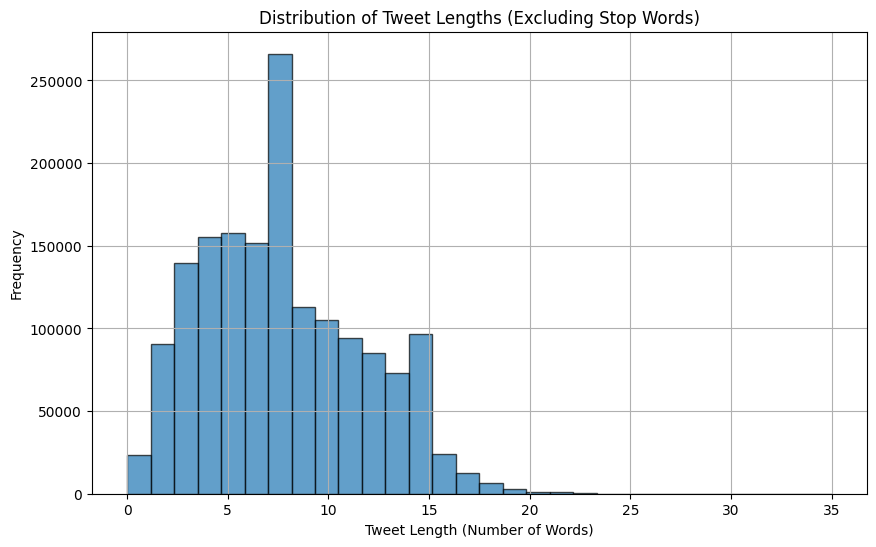

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Compute the length of each tweet after removing stop words
tweet_lengths_rdd = filtered_tweets_words_rdd.map(lambda words: len(words))

# Step 2: Collect tweet lengths as a list
tweet_lengths = tweet_lengths_rdd.collect()

# Step 3: Calculate the median length
median_length = np.median(tweet_lengths)

# Step 4: Display the median tweet length
print(f"The median tweet length (excluding stop words) is: {median_length}")

# Step 5: Plot the histogram for tweet length distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Tweet Lengths (Excluding Stop Words)')
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [17]:
from collections import Counter

# Step 1: Convert all words to lowercase
lowercase_words_rdd = filtered_tweets_words_rdd.flatMap(lambda words: [word.lower() for word in words])

# Step 2: Count the occurrences of each word
word_counts = lowercase_words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

# Step 3: Collect the word counts
word_counts_collected = word_counts.collect()

# Step 4: Sort by frequency and take the top 10 most common words
most_common_words = sorted(word_counts_collected, key=lambda x: x[1], reverse=True)[:10]

# Display the 10 most common words
print("Top 10 most common words (case-insensitive):")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")


Top 10 most common words (case-insensitive):
im: 178366 occurrences
good: 89420 occurrences
day: 84819 occurrences
get: 81600 occurrences
like: 77781 occurrences
go: 72982 occurrences
dont: 67300 occurrences
today: 64633 occurrences
going: 64099 occurrences
love: 63490 occurrences


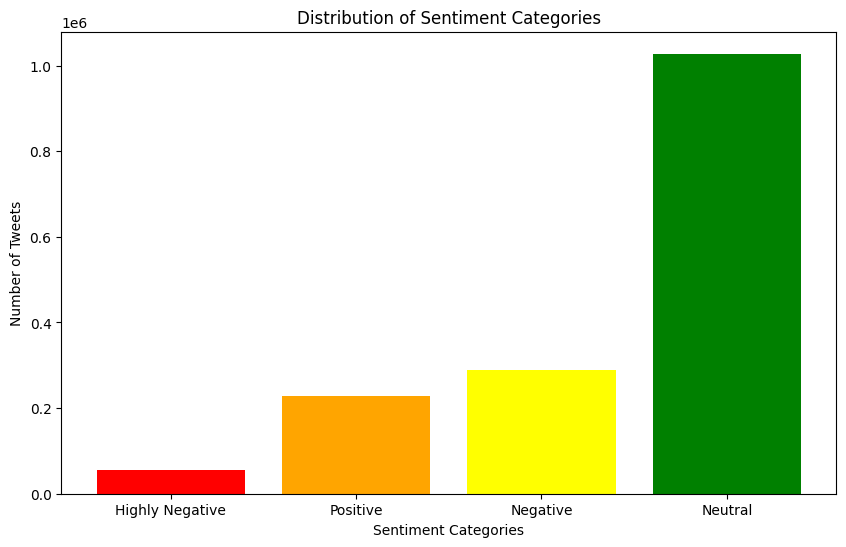

Sentiment category counts:
Highly Negative: 54370 tweets
Positive: 228125 tweets
Negative: 289874 tweets
Neutral: 1027631 tweets


In [18]:
# Step 1: Install TextBlob if not already installed
%pip install textblob

# Step 2: Import the required libraries
from textblob import TextBlob
import matplotlib.pyplot as plt

# Step 3: Define a function to calculate sentiment polarity
def get_sentiment_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Step 4: Apply the sentiment polarity function to the cleaned tweets RDD
# We'll calculate the sentiment polarity for each tweet in clean_tweets_rdd
tweet_sentiment_rdd = clean_tweets_rdd.map(lambda tweet: get_sentiment_polarity(tweet))

# Step 5: Define categories based on polarity
def categorize_sentiment(polarity):
    if polarity < -0.5:
        return 'Highly Negative'
    elif -0.5 <= polarity < 0:
        return 'Negative'
    elif 0 <= polarity < 0.5:
        return 'Neutral'
    else:
        return 'Positive'

# Step 6: Categorize each tweet's sentiment
sentiment_category_rdd = tweet_sentiment_rdd.map(categorize_sentiment)

# Step 7: Count the number of tweets in each sentiment category
sentiment_counts = sentiment_category_rdd.map(lambda category: (category, 1)).reduceByKey(lambda a, b: a + b).collect()

# Step 8: Extract categories and their counts
categories, counts = zip(*sentiment_counts)

# Step 9: Plot the distribution of sentiment categories using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['red', 'orange', 'yellow', 'green'])
plt.xlabel('Sentiment Categories')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiment Categories')
plt.show()

# Display the counts for each category
print("Sentiment category counts:")
for category, count in sentiment_counts:
    print(f"{category}: {count} tweets")


<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [20]:
# Step 1: Initialize a Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TweetInfoAnalysis").getOrCreate()

# Step 2: Unzipping the tweet_info file if it's not unzipped already
import zipfile
import os

zip_file_path = 'tweet_info.zip'
local_extracted_folder = './tweet_info/'

if not os.path.exists(local_extracted_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(local_extracted_folder)

# Step 3: Path to the tweet_info.csv file
csv_file_path = os.path.join(local_extracted_folder, 'tweet_info.csv')

# Step 4: Load the tweet_info.csv file into a Spark DataFrame
tweet_data = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Step 5: Show the first few records of the DataFrame to verify
tweet_data.show()

# Step 6: Test to ensure the tweet_data DataFrame has been loaded correctly
assert type(tweet_data) == pyspark.sql.dataframe.DataFrame


+--------------------+--------------------+-------------------+-------------------+----------------+--------+-----+---------+----------+
|             TweetID|              UserID|       FirstRetweet|     ActualPostTime|        Hashtags|Retweets|Likes|DayOfWeek|IsPromoted|
+--------------------+--------------------+-------------------+-------------------+----------------+--------+-----+---------+----------+
|0291d456-a441-441...|13888479-f9a2-412...|2023-10-03 11:42:42|2023-09-25 18:57:50|           #data|      15|  454|  Tuesday|         0|
|b670ce25-bea2-4d2...|a95a80b7-2569-498...|2023-10-04 11:06:37|2023-09-30 18:57:50|        #science|     423|  123| Saturday|         1|
|1adfe433-1379-483...|0d5baef7-dbb7-4db...|2023-10-15 00:11:09|2023-09-27 18:57:50|           #data|     476|  252|   Sunday|         1|
|2dcad08c-3fac-41c...|3ae01c22-e66b-468...|2023-10-10 21:14:52|2023-09-27 18:57:50|           #data|     118|  377|  Tuesday|         0|
|dac1f631-bf07-448...|57d1edcd-7dc0-46a..

In [21]:
# Step 1: Count the number of unique users in the DataFrame
nb_unique_users = tweet_data.select("UserID").distinct().count()

# Step 2: Print the result to verify
print(f"Number of unique users: {nb_unique_users}")

# Step 3: Test your solution
assert type(nb_unique_users) is int, "The result should be an integer."
assert nb_unique_users <= 1000, "There should be fewer than or equal to 1000 unique users."
assert 0 < nb_unique_users, "There should be more than 0 unique users."

print("Test passed for Question 3.2!")


Number of unique users: 96
Test passed for Question 3.2!


In [24]:
from pyspark.sql import functions as F

# Step 1: Filter the DataFrame to keep only promoted tweets
promoted_tweets = tweet_data.filter(tweet_data["IsPromoted"] == 1)

# Step 2: Group the promoted tweets by UserID and count the number of promoted tweets per user
promoted_counts = promoted_tweets.groupBy("UserID").agg(F.count("*").alias("NbPromoted"))

# Step 3: Sort the result by NbPromoted in decreasing order
promoted_counts_sorted = promoted_counts.orderBy(F.desc("NbPromoted"))

# Step 4: Show the result to verify
promoted_counts_sorted.show(10)

# No asserts are provided for this question


+--------------------+----------+
|              UserID|NbPromoted|
+--------------------+----------+
|f7696e45-bfb4-4bf...|        11|
|f10caa0e-e842-497...|        10|
|59516517-f347-494...|        10|
|e8a51290-a908-481...|        10|
|99b23fbd-1605-473...|        10|
|21a9c07e-936b-4dc...|         9|
|1862a287-0cfa-4cd...|         9|
|020fec0b-03f3-436...|         9|
|18ab7b08-6a95-4f1...|         8|
|a06bf394-22b8-4c6...|         8|
+--------------------+----------+
only showing top 10 rows



In [30]:
from pyspark.sql import functions as F

# Step 1: Calculate the time difference between FirstRetweet and ActualPostTime in hours
time_diff = (F.unix_timestamp(F.col("FirstRetweet")) - F.unix_timestamp(F.col("ActualPostTime"))) / 3600

# Step 2: Filter out the tweets where the time difference is less than or equal to 24 hours
retweeted_within_24h = tweet_data.filter(time_diff <= 24)

# Step 3: Group by UserID and count the retweets within 24 hours
tweets_count = retweeted_within_24h.groupBy("UserID").agg(F.count("*").alias("CountRetweeted24h"))

# Step 4: Sort the result by CountRetweeted24h in descending order
tweets_count_sorted = tweets_count.orderBy(F.desc("CountRetweeted24h"))

# Show the result
tweets_count_sorted.show(10)


+--------------------+-----------------+
|              UserID|CountRetweeted24h|
+--------------------+-----------------+
|614a2fbd-67cf-404...|                8|
|b7a352c0-99de-480...|                7|
|99b23fbd-1605-473...|                7|
|f7696e45-bfb4-4bf...|                7|
|c36da133-1750-4d2...|                6|
|d803c5a7-b88c-400...|                6|
|4f779980-b078-43c...|                6|
|f10caa0e-e842-497...|                6|
|e319c93a-255f-494...|                6|
|59516517-f347-494...|                6|
+--------------------+-----------------+
only showing top 10 rows



In [32]:
from pyspark.sql import functions as F

# Step 1: Extract the day of the week from the ActualPostTime
tweet_data_with_day = tweet_data.withColumn("DayOfWeek", F.date_format(F.col("ActualPostTime"), "EEEE"))

# Step 2: Calculate the time difference between FirstRetweet and ActualPostTime in hours
time_diff = (F.unix_timestamp(F.col("FirstRetweet")) - F.unix_timestamp(F.col("ActualPostTime"))) / 3600

# Step 3: Filter out the tweets where the time difference is less than or equal to 24 hours
retweeted_within_24h = tweet_data_with_day.filter(time_diff <= 24)

# Step 4: Group by UserID, DayOfWeek and count the retweets within 24 hours
result = retweeted_within_24h.groupBy("UserID", "DayOfWeek").agg(F.count("*").alias("CountRetweeted24h"))

# Step 5: Sort by CountRetweeted24h in descending order, then by UserID and DayOfWeek
result_sorted = result.orderBy(F.col("CountRetweeted24h").desc(), "UserID", "DayOfWeek")

# Show the result
result_sorted.show(10)


+--------------------+---------+-----------------+
|              UserID|DayOfWeek|CountRetweeted24h|
+--------------------+---------+-----------------+
|59516517-f347-494...|   Friday|                3|
|5d1d6c61-68e4-42c...|   Friday|                3|
|614a2fbd-67cf-404...| Saturday|                3|
|85918606-a704-4bd...|   Friday|                3|
|99b23fbd-1605-473...|   Sunday|                3|
|9baeea4c-abad-4fe...|   Sunday|                3|
|a06bf394-22b8-4c6...|   Friday|                3|
|e8a51290-a908-481...|   Sunday|                3|
|f7696e45-bfb4-4bf...|   Friday|                3|
|081571de-5c93-479...|   Monday|                2|
+--------------------+---------+-----------------+
only showing top 10 rows



In [33]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark
spark = SparkSession.builder.appName("ThreeDSpaceSampling").getOrCreate()

# Generate 1,000,000 random points in 3D space
num_points = 1_000_000
points_3d = [(np.random.uniform(-1000, 1000),
              np.random.uniform(-1000, 1000),
              np.random.uniform(-1000, 1000)) for _ in range(num_points)]

# Create a Spark DataFrame from the points
points_df = spark.createDataFrame([Row(x=x, y=y, z=z) for x, y, z in points_3d])

# Show some sample points
points_df.show(5)

+------------------+-------------------+------------------+
|                 x|                  y|                 z|
+------------------+-------------------+------------------+
|-770.5924764532863| -428.6467361096809| 531.0521704542489|
|-580.7777954112287| -620.2491183533034| 779.9997883552328|
| 979.3220032534948| -292.5043533161229| 925.8922547795457|
|-689.1799309730804|  705.7788378136395|-598.9878408118097|
|-861.2032936426539|-220.04026293214542|155.48485343473635|
+------------------+-------------------+------------------+
only showing top 5 rows



In [34]:
# Define arbitrary vectors for the grid
v1 = np.array([1, 1, 1])  # First arbitrary vector for the grid
v2 = np.cross(v1, [1, 0, 0])  # Generate the second orthogonal vector using cross product
v3 = np.cross(v1, v2)  # Third orthogonal vector by crossing the first two

# Normalize vectors to make them unit vectors
v1 = v1 / np.linalg.norm(v1)
v2 = v2 / np.linalg.norm(v2)
v3 = v3 / np.linalg.norm(v3)

print(f"Vector 1 (v1): {v1}")
print(f"Vector 2 (v2): {v2}")
print(f"Vector 3 (v3): {v3}")

Vector 1 (v1): [0.57735027 0.57735027 0.57735027]
Vector 2 (v2): [ 0.          0.70710678 -0.70710678]
Vector 3 (v3): [-0.81649658  0.40824829  0.40824829]


In [35]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType

# Define UDF to assign points to grid cells
@udf(returnType=StructType([StructField("i", IntegerType()),
                            StructField("j", IntegerType()),
                            StructField("k", IntegerType())]))
def assign_grid_cell(x, y, z):
    # Project the point onto each of the vectors v1, v2, and v3
    point = np.array([x, y, z])
    i = int(np.dot(point, v1) // 10)  # Adjusting grid size with 10 units per cell
    j = int(np.dot(point, v2) // 10)
    k = int(np.dot(point, v3) // 10)
    return {"i": i, "j": j, "k": k}

# Add a column for the grid cell
points_with_grid = points_df.withColumn("grid_cell", assign_grid_cell("x", "y", "z"))

# Show the points with grid cell assignments
points_with_grid.show(5, truncate=False)


+------------------+-------------------+------------------+---------------+
|x                 |y                  |z                 |grid_cell      |
+------------------+-------------------+------------------+---------------+
|-770.5924764532863|-428.6467361096809 |531.0521704542489 |{-39, -68, 67} |
|-580.7777954112287|-620.2491183533034 |779.9997883552328 |{-25, -100, 53}|
|979.3220032534948 |-292.5043533161229 |925.8922547795457 |{93, -87, -55} |
|-689.1799309730804|705.7788378136395  |-598.9878408118097|{-34, 92, 60}  |
|-861.2032936426539|-220.04026293214542|155.48485343473635|{-54, -27, 67} |
+------------------+-------------------+------------------+---------------+
only showing top 5 rows



In [36]:
# Group points by grid cell and sample 10 points from each cell
sampled_points = points_with_grid.groupBy("grid_cell").agg(F.collect_list(F.struct("x", "y", "z")).alias("points"))

# Show the sampled points for each grid cell
sampled_points.show(5, truncate=False)


+-------------+--------------------------------------------------------------+
|grid_cell    |points                                                        |
+-------------+--------------------------------------------------------------+
|{-172, 0, -1}|[{-986.5533385070111, -985.0515950584106, -995.2162588471444}]|
|{-171, -2, 1}|[{-996.1477816883175, -990.89287944644, -974.0814385213505}]  |
|{-170, -4, 1}|[{-985.7684603850545, -994.9845806856346, -949.3472865168961}]|
|{-170, -3, 1}|[{-990.6370939747271, -988.4911360279877, -959.1408954755245}]|
|{-169, 2, 3} |[{-998.2483401775868, -943.1420776409547, -979.5353289247723}]|
+-------------+--------------------------------------------------------------+
only showing top 5 rows

